# Evaluation trained discrete model of a Lagrangian density

## Loading and initialisation of the trained model

In [16]:
# load packages
using JSON
using SplitApplyCombine
#using Plots
using Random
using DelimitedFiles

# load tools
include("9ptStencil.jl")
include("SpectralTools.jl")
include("plotting_tools.jl")
include("LdNetworkArchitecture.jl")

# load model and latest update to parameters
run_data=JSON.parsefile("Schroedinger_2023-04-21_10-49-13training_data.json");
run_data_update0=JSON.parsefile("423_2023-04-27_14-07-37run_param_data.json")
run_data["learned_parameters"] = run_data_update0["learned_parameters"];
training_losses1 = readdlm("losses_postprocessed_run1.txt");
training_losses2 = readdlm("losses_continue1.txt");
training_losses = [training_losses1;training_losses2];

In [12]:
# details of two consecutive training sessions
ep1 = 70:70:70*16
ep2 = ep1[end]+1:ep1[end]+424
ep=[ep1;ep2];

println("final loss / regulariser "*string(training_losses[end,:])*"\n")
print("last saved epoch "*string(ep[end]))

final loss / regulariser [8.037582654734983e-5, 0.0]

last saved epoch 1544

In [13]:
# define reference Lagrangian for tests
V(r) = r
alpha(u) = [u[2];-u[1]]
H(u,ux) = sum(ux.^2) + V(sum(u.^2))
Lagrangian_ref(u,ut,ux) = dot(alpha(u),ut)-H(u,ux)
Lagrangian_ref_d,Lagrangian_ref_semi_dx,Lagrangian_ref_semi_d,firstStep_ref = DiscretiseLDensity(Lagrangian_ref)
function Lagrangian_ref(uJet1);    u=uJet1[:,1]; ut=uJet1[:,2]; ux=uJet1[:,3];    return Lagrangian_ref(u,ut,ux); end

Lagrangian_ref (generic function with 2 methods)

In [14]:
# set parameters of space-time domain
l = 1. # length of spatial domain including (periodic) boundary
T = .12 # final time

# discretisation parameters
M = length(run_data["training_data"][1][1]) # spatial grid points 
N = length(run_data["training_data"][1])-1 # time steps

dx = l/M # periodic boundary conditions
dt = T/N

# initial values (periodic)
XMesh   = 0:dx:(M-1)*dx
XMeshbd = 0:dx:M*dx # repeat boundary
TMesh = 0:dt:N*dt

0.0:0.01:0.12

In [17]:
NNwidth = 12
LdArchitecture, _ = InitLd(MersenneTwister(4321),NNwidth=NNwidth,sigma=softplus);

In [18]:
# periodic spatial indices
modInd(i::Int) = mod(i-1,M)+1

# define learned functions from learned model
paramVec = Float64.(run_data["learned_parameters"]);
learned_Ld(z) = LdArchitecture(paramVec,z)
Learned_Ld(u,uup,uright,uupright) = LdArchitecture(paramVec,reshape([u uup uright uupright],8))
Learned_Ldxd(U0,U1) = sum([Learned_Ld(U0[:,j],U1[:,j],U0[:,modInd(j+1)],U1[:,modInd(j+1)]) for j=1:M])
Learned_Ldx(U,Ud) = Learned_Ldxd(U-dt/2*Ud,U+dt/2*Ud)

Learned_Ldx (generic function with 1 method)

In [20]:
# read and process training data for presentation
converter  = x-> hcat(x...)
converter2 = x -> converter.(x)
converter3 = x -> converter2.(x)

training_data = permutedims(combinedims(combinedims(converter3(run_data["training_data"]))),[1,3,2,4])
size(training_data)

(2, 13, 8, 80)

In [27]:
# function for plotting
plotU, contourU, contourU!,plotAllU = InstantiatePlotFun(dt,dx)

(plotU, contourU, contourU!, plotAllU)

## Model evaluation
### reproduction of solutions seen during training

In [31]:
# check whether training data can be reproduced
function DELSolveEvaluate(training_data)
    LEval = zeros(size(training_data))

    for k = 1:size(training_data,4)    
        U_ref=training_data[:,:,:,k]
        u0 = U_ref[:,1,:]
        u1 = U_ref[:,2,:]
        LEval[:,:,:,k]=permutedims(DELSolve(Learned_Ldxd,u0,u1,N),[1,3,2]);
    end
return LEval
end

DELSolveEvaluate (generic function with 1 method)

In [32]:
UQs_ref,UPs_ref,CQs_ref,CPs_ref = plotAllU(training_data);

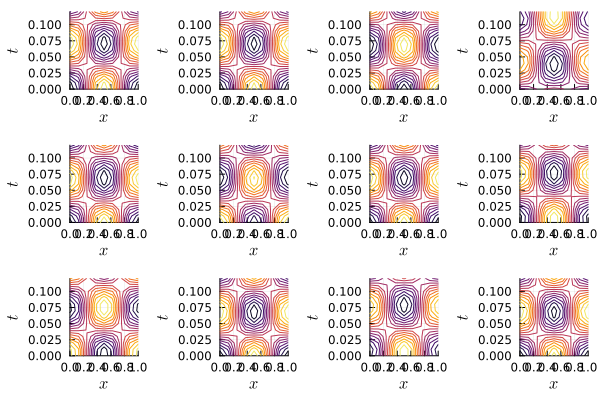

In [37]:
# plot of (subset of) training data
plotrange = 10:21
plot(CQs_ref[plotrange]...)

In [34]:
LEval = DELSolveEvaluate(training_data);
UQs,UPs,CQs,CPs = plotAllU(LEval);

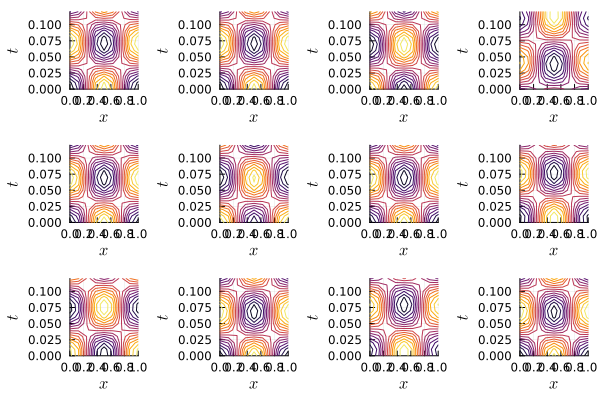

In [38]:
# plot of (subset of) reproduced data with ml model
plot(CQs[plotrange]...)

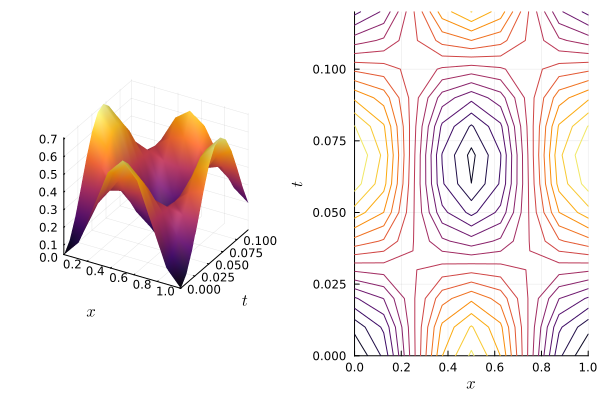

In [101]:
# plotting

SampleNo = 35

U_ref=training_data[:,:,:,SampleNo]
plot(plotU(training_data[1,:,:,SampleNo]),contourU(training_data[1,:,:,SampleNo]))

In [126]:
#plotU(training_data[1,:,:,SampleNo])
#plot!(size=(300,200),xticks=3,yticks=4,zticks=4)
#plot!(dpi=600)
#savefig("pics/training_data_sample35.png")

In [127]:
u0 = U_ref[:,1,:]
u1 = U_ref[:,2,:]
U=permutedims(DELSolve(Learned_Ldxd,u0,u1,50),[1,3,2]);

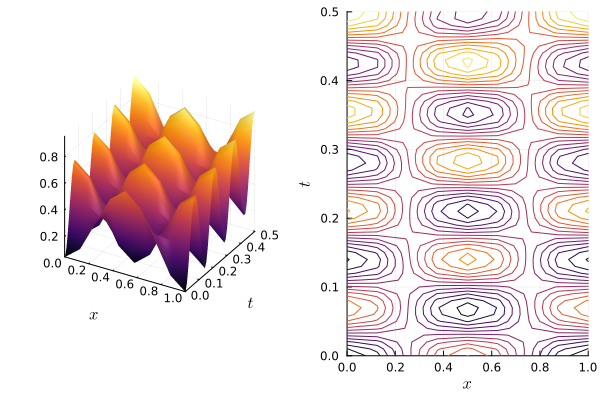

In [128]:
iMax = size(U,2)
plot(plotU(U[1,1:iMax,:]),contourU(U[1,1:iMax,:]),layout=(1,2))

In [132]:
#plot(plotU(U[1,1:iMax,:]))
#plot!(size=(300,200),xticks=3,yticks=4,zticks=3)
#plot!(dpi=600)
#savefig("pics/data_sample35_continue_with_learnedLd.png")

In [133]:
function Lagrangian_ref_dInst(u,uup,uright,uupright); return Lagrangian_ref_d(dx,dt,u,uup,uright,uupright); end
function Lagrangian_ref_semi_dInst(U0,U1); return Lagrangian_ref_semi_d(dt,dx,U0,U1); end

Lagrangian_ref_semi_dInst (generic function with 1 method)

In [134]:
U_refExt=permutedims(DELSolve(Lagrangian_ref_semi_dInst,u0,u1,size(U,2)),[1,3,2]);

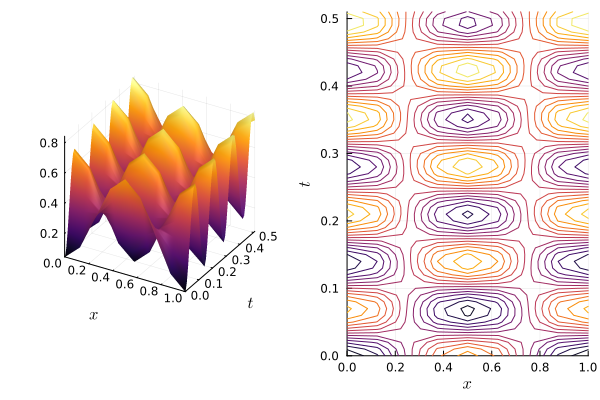

In [135]:
plot(plotU(U_refExt[1,:,:]),contourU(U_refExt[1,:,:]),layout=(1,2))

In [139]:
#plot(plotU(U_refExt[1,1:iMax,:]))
#plot!(size=(300,200),xticks=3,yticks=4,zticks=3)
#plot!(dpi=600)
#Plots.savefig("pics/data_sample35_continue_with_Ld_ref.png")

In [140]:
# data consistency
sqrt(DataConsistency(Lagrangian_ref_dInst,permutedims(U_ref,[1,3,2]))*dt*dx)/(T*l),
sqrt(DataConsistency(Lagrangian_ref_dInst,permutedims(U,[1,3,2]))*dt*dx)/(T*l),
sqrt(DataConsistency(Learned_Ld,permutedims(U,[1,3,2]))*dt*dx)/(T*l),
sqrt(DataConsistency(Learned_Ld,permutedims(U_ref,[1,3,2]))*dt*dx)/(T*l)

(4.337316278875878e-14, 14.540894975556968, 4.3749382478265823e-10, 0.0011183320040651144)

In [141]:
# how constant is the learned Lagrangian
learned_Ld(rand(8)),Lagrangian_ref_dInst(rand(2),rand(2),rand(2),rand(2))

(3.107128515722584, -6.481982722623134)

In [260]:
# error
U_extrapolate_err=U_ref[:,1:min(size(U,2),size(U_ref,2)),:]-U[:,1:min(size(U,2),size(U_ref,2)),:]
maximum(abs.(U_extrapolate_err[1,:,:]+1.0im*U_extrapolate_err[2,:,:]))

0.01151600580003791

### unseen initial values

In [247]:
u0 = [0.3*sin.(2*pi/l*XMesh)'; 0.0*sin.(2*pi/l*XMesh)']
u1 = [0.3*sin.(2*pi/l*XMesh)'; 0.0*sin.(2*pi/l*XMesh)']

NSteps=12

U_unseen_ref=DELSolve(Lagrangian_ref_semi_dInst, u0, u1,NSteps);

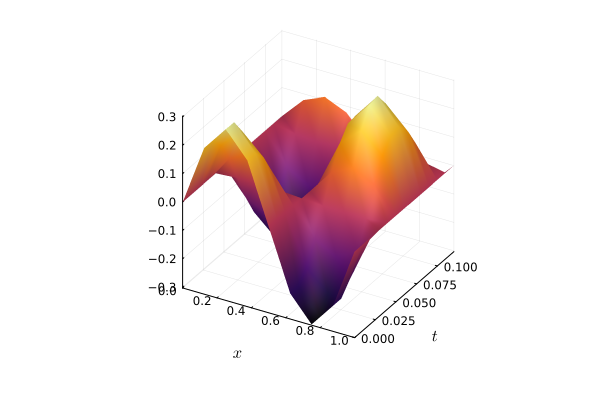

In [248]:
plotU(U_unseen_ref[1,:,:]')

In [249]:
U_unseen=DELSolve(Learned_Ldxd, u0, u1,NSteps);

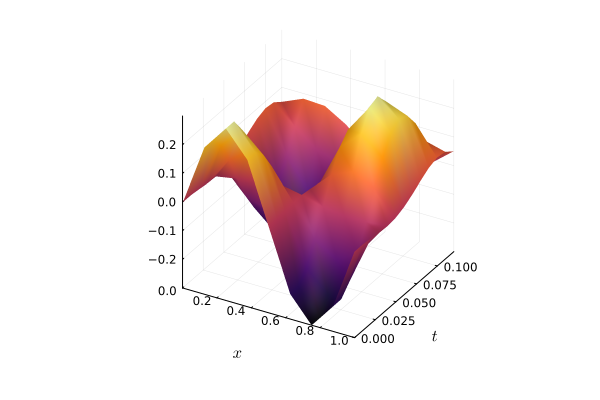

In [250]:
plotU(U_unseen[1,:,:]')

In [254]:
# error
U_unseen_err=U_unseen-U_unseen_ref
maximum(abs.(U_unseen_err[1,:,:]+1.0im*U_unseen_err[2,:,:]))

0.39549332429734824

## Travelling Waves

### Are traveling waves of Ld_ref also travelling waves of the learned model Ld_ML?

#### TW of the discrete travelling wave equation (reference)

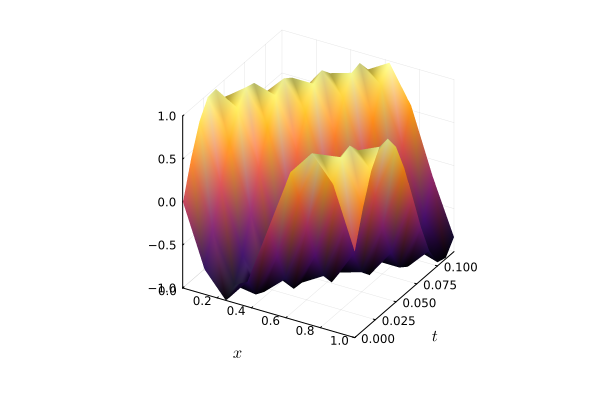

In [197]:
wave_no = 1

theta = 2*pi*wave_no/l   # imaginary unit not included


Vd = 1
hbar = 1
c_tw_discrete = 2/(theta*dt)*atan(2/hbar*dt/dx^2*tan(1/2*theta*dx)^2+Vd*dt/(2*hbar))     #+ 2/(theta*dt)*s*pi, s \in \Z

amplitude_discrete = 0.0 + 1.0*im
tw_discrete(t,x) = amplitude_discrete*exp(im*theta*(x-c_tw_discrete*t))
Psi_tw_discrete = tw_discrete.(TMesh,transpose(XMesh))
U_tw_discrete = cat(real.(Psi_tw_discrete),imag.(Psi_tw_discrete),dims=3)
U_tw_discrete = permutedims(U_tw_discrete,[3,2,1])

plotU(real.(Psi_tw_discrete))

In [179]:
#plot!(size=(300,200),xticks=3,yticks=4,zticks=3)
#plot!(dpi=600)
#savefig("pics/Schroedinger_TW_discrete_reference.png")

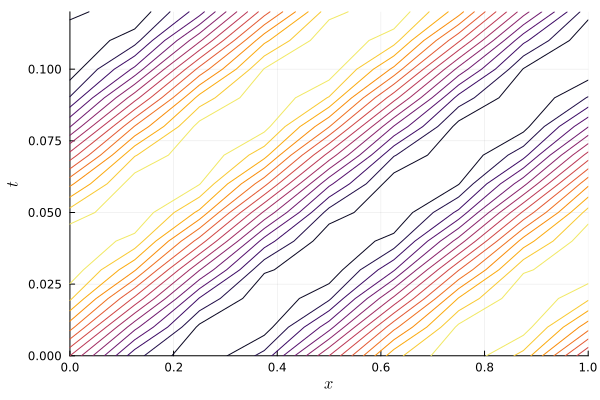

In [180]:
contourU(real.(Psi_tw_discrete))

In [181]:
DataConsistency(Lagrangian_ref_dInst,U_tw_discrete)

1.7549157469727673e-25

In [182]:
DataConsistency(Learned_Ld,U_tw_discrete)

0.0021529344138611784

### Replication of travelling waves of discrete field theory

In [183]:
u0 = U_tw_discrete[:,:,1]
u1 = U_tw_discrete[:,:,2]
U_unseen_TW=DELSolve(Learned_Ldxd, u0, u1,N);

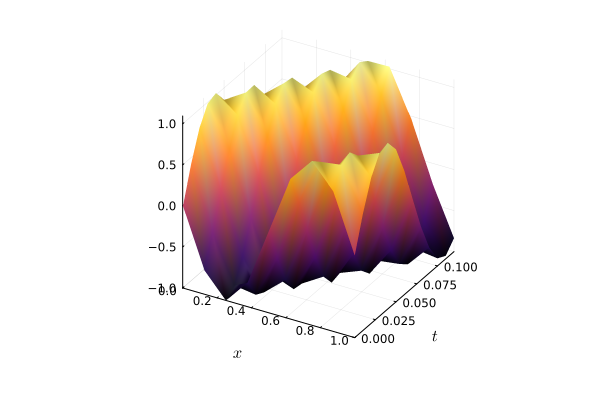

In [184]:
plotU(U_unseen_TW[1,:,:]')

In [185]:
#plot!(size=(300,200),xticks=3,yticks=4,zticks=3)
#plot!(dpi=600)
#Plots.savefig("pics/Schroedinger_TW_learned_model_initialised_from_ref.png")

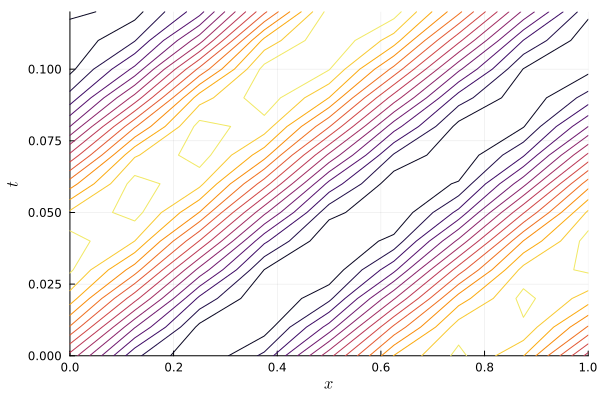

In [186]:
contourU(U_unseen_TW[1,:,:]')

In [242]:
# error of prediction
maximum(abs.(transpose(Psi_tw_discrete) - (U_unseen_TW[1,:,:] + 1.0im * U_unseen_TW[2,:,:])))

0.19181031112518845

##### spurious solutions (does not correspond to tw in continuous Schroedinger)

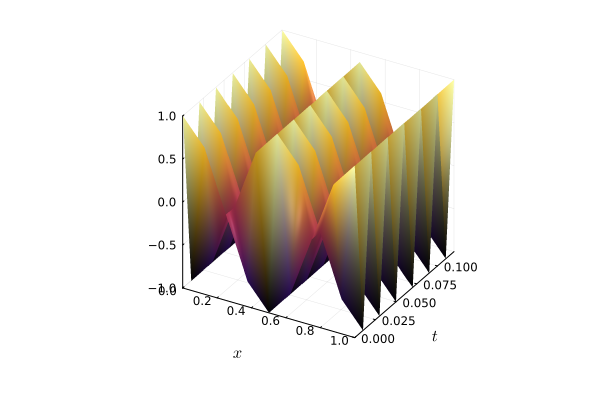

In [171]:
wave_no = 1
theta = 2*pi*im*wave_no/l

c_tw_discrete= l / (2*wave_no*dt)  # plus minus

amplitude_discrete = [1.,0.]
tw_discrete(t,x) = amplitude_discrete[1]*exp(theta*(x-c_tw_discrete*t))+amplitude_discrete[2]*exp(theta*(x-c_tw_discrete*t))
Psi_tw_discrete = tw_discrete.(TMesh,transpose(XMesh))
U_tw_discrete = cat(real.(Psi_tw_discrete),imag.(Psi_tw_discrete),dims=3)
U_tw_discrete = permutedims(U_tw_discrete,[3,2,1])

#print("consistency with DEL: "); print(maximum(abs.(DELTest(Lagrangian_ref_d,U_tw_discrete))))
plotU(real.(Psi_tw_discrete))

In [173]:
#plot!(size=(300,200),xticks=3,yticks=4,zticks=3)
#plot!(dpi=600)
#Plots.savefig("pics/Schroedinger_TW_spurious_ref.pdf")

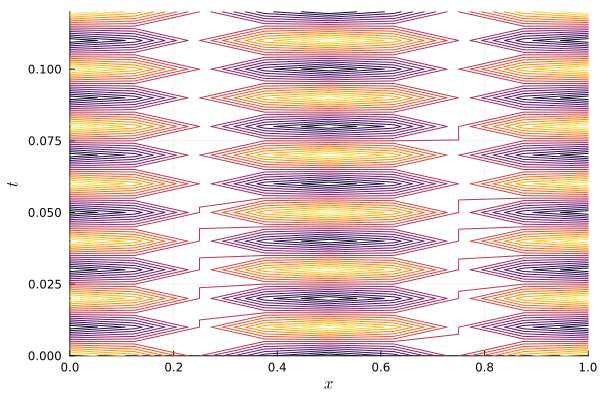

In [164]:
contourU(real.(Psi_tw_discrete))

In [170]:
#plot!(size=(300,200),xticks=3,yticks=4,zticks=3)
#plot!(dpi=600)
#Plots.savefig("pics/Schroedinger_TW_spurious_ref_contour.pdf")

In [78]:
DataConsistency(Lagrangian_ref_dInst,U_tw_discrete)

5.97232076302172e-24

In [80]:
DataConsistency(Learned_Ld,U_tw_discrete) # spuriour solution is not present in the learned model

523.9114179685357